###### For my Final Project I set a goal to try to use data from soccer matches to predict the results of those matches.  I got a trial API key from SportRadar and pulled down their data for MLS matches into a MySQL Database.  Their data consisted of some basic stats such as scores, shots, fouls, corner kicks but also some advanced stats such as possession, dangerous attacks, ball safe, etc...  Using the data pulled from the database, I made some calculations that weren't available from the API but important in Soccer matches such as Goal Differential and teams Strength of Schedule.  Using this data, I ran multiple models using various features to discover the best model to predict which team will win/lose.

SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 26
target_col = 'points'
ignore_cols = ['games_played', 'match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled']
models = ['log', 'svc', 'gmm', 'knn', 'gnb']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


Pulling in the data either from the Database or the CSV (CSV for testers).  Data has some added features in between the database and 'raw_data'.  Essentially trying 3 different versions of the data in this set.  One version contains all the features.  Another version has the standard features plus the calculated features of the home/away stats for a matchup.  The last version has the standard features plus the 'extended features' which not only includes the stats of the two teams in the match up but also the current teams previous opponents and the current teams opponents of the team opponents in that matchup.

In [66]:
match_details = form_data.get_coverage()
# print(match_details.shape)
display(match_details.head())

,match_id,scheduled,round,home_team,home_id,home_formation,home_score,home_points,home_first_half_score,home_second_half_score,home_attacks,home_ball_safe,home_corner_kicks,home_dangerous_attacks,home_fouls,home_offsides,home_yellow_card,home_shots_on_target,home_shots_total,home_possession,away_team,away_id,away_formation,away_score,away_points,away_first_half_score,away_second_half_score,away_attacks,away_ball_safe,away_corner_kicks,away_dangerous_attacks,away_fouls,away_offsides,away_yellow_card,away_shots_on_target,away_shots_total,away_possession
0,1,2016-03-06 18:30:00,1,NY Red Bulls,31,4-2-3-1,0,0,0,0,143,115,2,77,12,4,1,0,7,48,Toronto FC,34,4-3-3,2,3,0,2,111,128,4,50,9,5,2,6,10,52
1,2,2016-03-06 19:00:00,1,Orlando City SC,35,4-3-3,2,1,0,2,NaN,45,12,49,14,4,2,7,14,50,Real Salt Lake,23,4-2-3-1,2,1,1,1,NaN,50,2,34,11,1,2,4,8,50
2,3,2016-03-06 19:00:00,1,Chicago Fire,40,4-2-3-1,3,0,1,2,77,83,12,41,11,7,2,9,12,34,New York City FC,24,4-3-3,4,3,3,1,103,75,1,48,9,1,2,8,12,66
3,4,2016-03-06 20:00:00,1,Houston Dynamo,38,4-2-3-1,3,1,1,2,65,66,5,44,10,1,1,5,14,48,New England Revolution,36,4-2-3-1,3,1,1,2,74,75,2,51,17,4,2,6,13,52
4,5,2016-03-06 20:00:00,1,San Jose Earthquakes,32,4-4-2,1,3,0,1,88,75,3,41,15,1,2,3,3,52,Colorado Rapids,22,4-2-3-1,0,0,0,0,86,80,5,39,15,2,2,6,11,48


In [79]:
pd.crosstab(match_details['home_score'], 
            match_details.replace({'home_points': {0: 'lose', 1: 'tie', 3: 'win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)

home_points,lose,tie,win
home_score,,,
0,0.078125,0.070312,0.000000
1,0.074219,0.148438,0.128906
2,0.015625,0.089844,0.187500
3,0.007812,0.007812,0.121094
4,0.000000,0.003906,0.046875
5,0.000000,0.000000,0.015625
6,0.000000,0.000000,0.003906


In [80]:
pd.crosstab(match_details['away_score'], 
            match_details.replace({'away_points': {0: 'lose', 1: 'tie', 3: 'win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_points,lose,tie,win
away_score,,,
0,0.277344,0.070312,0.000000
1,0.152344,0.148438,0.035156
2,0.062500,0.089844,0.074219
3,0.011719,0.007812,0.042969
4,0.000000,0.003906,0.019531
7,0.000000,0.000000,0.003906


In [14]:
pd.crosstab(match_details['away_score'], 
            match_details['away_shots_total'])

away_shots_on_target,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,13.0
away_score,,,,,,,,,,,
0,5,10,13,22,14,12,6,1,0,0,0
1,0,5,18,11,16,15,10,0,0,2,0
2,0,0,1,8,12,14,7,7,3,2,0
3,0,0,1,0,2,5,6,0,0,0,0
4,0,0,0,0,0,1,1,1,1,0,1


In [17]:
pd.crosstab(match_details['home_score'], 
            match_details['home_shots_total'])

home_shots_total,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,21.0,24.0
home_score,,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,1,0,3,3,7,5,0,4,4,2,0,0,1,0,1,0,0,0
1,0,1,0,4,1,2,7,3,7,11,15,6,8,6,4,2,1,1,1,1,0,0
2,0,0,0,0,0,3,3,3,6,9,5,8,11,10,6,1,2,1,0,0,1,1
3,0,0,0,0,0,0,2,0,1,2,5,3,7,3,5,2,2,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,1,3,0,0,1,1,1,2,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [2]:
data_csv = 'round' + str(round_number) + '.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)

print('Data Loaded...')

Data Loaded...


In [ ]:
def plot_PCA(data, preds):
    
    pca = PCA(n_components=2)
    pca.fit(data)
    # Generate PCA results plot
    # pca_results = rs.pca_results(data, pca)
    
    reduced_data = pca.transform(data)
    # Create a DataFrame for the reduced data
    reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
    plot_data = pd.concat([preds, reduced_data], axis = 1)
    display(plot_data.head())
    fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('points'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);
    
    return pca
pca = plot_PCA(raw_X, raw_y)

## Extended Features RELATIONSHIPS

In [ ]:
columns = ['e_f_shots_on_target', 'e_f_ball_safe', 'e_f_possession', 'e_f_attacks', 'e_f_dangerous_attacks', 'e_f_shots_total', 
           'points']
extended_features = raw_data[columns]
display(extended_features.head())

for c in range(len(columns)):
    if c < (len(columns)-1): 
        compare = (len(columns)-2) - c
        for x in (range(compare)):
            fig, ax = plt.subplots(figsize = (14,8))
            cmap = cm.get_cmap('gist_rainbow')

            for i, cluster in extended_features.groupby('points'):   
                cluster.plot(ax = ax, kind = 'scatter', x = columns[c], y = columns[x+1+c], 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);


In [ ]:
#print(match_details)
cols = ['home_attacks', 'home_ball_safe', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())
print(rels.shape)

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('home_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'home_attacks', y = 'home_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

In [ ]:
#print(match_details)
cols = ['away_attacks', 'away_ball_safe', 'away_points']
rels = match_details[cols]
rels = rels.dropna()
display(rels.head())

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in rels.groupby('away_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'away_attacks', y = 'away_ball_safe', 
                    color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

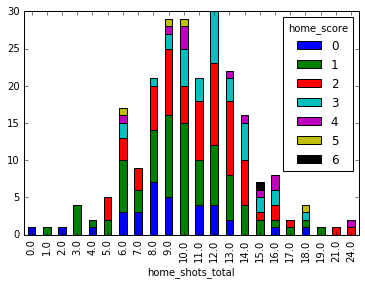

In [61]:
cols = ['home_shots_total', 'home_score', 'home_points']
rels = match_details[cols]
rels = rels.dropna()
# print(rels.groupby('home_shots_total').groups)
rels = rels.sort_values('home_shots_total')
#print(rels)
#display(rels.head())

temp = pd.crosstab(rels['home_shots_total'], rels['home_score'])
temp.plot(kind='bar', stacked=True)

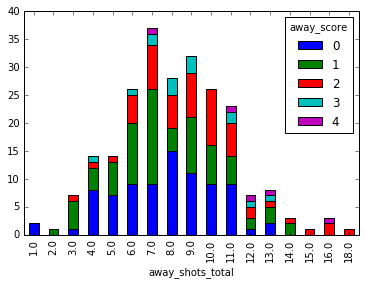

In [62]:
cols = ['away_shots_total', 'away_score', 'away_points']
rels = match_details[cols]
rels = rels.dropna()
# print(rels.groupby('home_shots_total').groups)
rels = rels.sort_values('away_shots_total')
#print(rels)
#display(rels.head())

temp = pd.crosstab(rels['away_shots_total'], rels['away_score'])
temp.plot(kind='bar', stacked=True)

In [76]:
conv_points = match_details
def set_group(goals):
    if goals >= 2:
        return 1
    elif goals < 2:
        return 0
    
conv_points['home_converted_score'] = conv_points.apply(lambda row: set_group(row['home_score']), axis=1)
conv_points = conv_points.drop('home_score', 1)

conv_points['away_converted_score'] = conv_points.apply(lambda row: set_group(row['away_score']), axis=1)
conv_points = conv_points.drop('away_score', 1) 

In [77]:
pd.crosstab(conv_points['away_converted_score'], 
            conv_points.replace({'away_points': {0: 'lose', 1: 'tie', 3: 'win'}})['away_points']).apply(lambda r: r/len(match_details), axis=1)

away_points,lose,tie,win
away_converted_score,,,
0,0.429688,0.218750,0.035156
1,0.074219,0.101562,0.140625


In [78]:
pd.crosstab(conv_points['home_converted_score'], 
            conv_points.replace({'home_points': {0: 'lose', 1: 'tie', 3: 'win'}})['home_points']).apply(lambda r: r/len(match_details), axis=1)

home_points,lose,tie,win
home_converted_score,,,
0,0.152344,0.218750,0.128906
1,0.023438,0.101562,0.375000


## Training

Functions that trains basic models (and saves them if need be).  'load_models' will  load exisiting models to save time in testing.

In [3]:
# Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

"""No Cross-Validation and No Tuning"""
def train_models(round_num, X, y):
    
    if os.path.isdir("/models/" + str(round_num)):
        print('Making New Directory for the Round')
        os.chdir('/Users/senzari/Machine_Learning/stats/src/models')
        os.makedirs(str(round_num))
        os.chdir('/Users/senzari/Machine_Learning/stats/src')
    
    for i in models:
        
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        
        
        if i == 'log':
            log = form_model.build_model(X, y, i)
            joblib.dump(log, model_round)
        elif i == 'svc':
            svc = form_model.build_model(X, y, i)
            joblib.dump(svc, model_round)
        elif i == 'gmm':
            gmm = form_model.build_model(X, y, i)
            joblib.dump(gmm, model_round)
        elif i == 'knn':
            kmeans = form_model.build_model(X, y, i)
            joblib.dump(kmeans, model_round)
        elif i == 'gnb':
            gnb = form_model.build_model(X, y, i)
            joblib.dump(gnb, model_round)
    
    return log, svc, gmm, kmeans, gnb
        
        
def load_models(round_num):
    
    for i in models:
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        if i == 'log':
             log= joblib.load(model_round)
        if i == 'svc':
             svc= joblib.load(model_round)
        elif i == 'gmm':
            gmm = joblib.load(model_round)
        elif i == 'knn':
            kmeans = joblib.load(model_round)
        elif i == 'gnb':
            gnb = joblib.load(model_round)
        
        print("Success :: Loaded - " + str(i))
        
    return log, svc, gmm, kmeans, gnb

raw_X, raw_y = split_target(raw_data)

#log, svc, gmm, knn, gnb = train_models(round_number, raw_X, raw_y)
# svc, gmm, knn, gnb = load_models(round_number)

In [63]:
pd.set_option('display.max_columns', 500)
new_data = raw_data.drop('points', 1)

def set_group(goals):
    if goals >= 2:
        return 1
    elif goals < 2:
        return 0
    
new_data['converted_points'] = new_data.apply(lambda row: set_group(row['goals']), axis=1)

new_data = new_data.drop('goals', 1)
new_data = model_libs._clone_and_drop(new_data, ignore_cols)

formations = []
for name in new_data.groupby('current_formation').groups:
    formations.append(name)
    
nd = np.array(formations) 

for name in new_data.groupby('opp_formation').groups:
    if name not in nd:
        print(nd.append(name))
        
for n in range(len(nd)):
    new_data = new_data.replace(nd[n], n)

(nd_y, nd_X) = model_libs._extract_target(new_data, 'converted_points')

display(nd_X.head(10))
display(nd_y.head(10))

log, svc, gmm, knn, gnb = train_models(round_number, nd_X, nd_y)

,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,win_percentage,sos,opp_is_home,opp_formation,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_diff,opp_win_percentage,opp_opp_record,current_team_home_possession,current_team_away_possession,current_team_home_attacks,current_team_away_attacks,current_team_home_dangerous_attacks,current_team_away_dangerous_attacks,current_team_home_yellow_card,current_team_away_yellow_card,current_team_home_corner_kicks,current_team_away_corner_kicks,current_team_home_shots_on_target,current_team_away_shots_on_target,current_team_home_shots_total,current_team_away_shots_total,current_team_home_ball_safe,current_team_away_ball_safe,current_team_home_played,current_team_away_played,current_opp_home_attacks,current_opp_away_attacks,current_opp_home_dangerous_attacks,current_opp_away_dangerous_attacks,current_opp_home_yellow_card,current_opp_away_yellow_card,current_opp_home_corner_kicks,current_opp_away_corner_kicks,current_opp_home_shots_on_target,current_opp_away_shots_on_target,current_opp_home_shots_total,current_opp_away_shots_total,current_opp_home_ball_safe,current_opp_away_ball_safe,current_opp_home_played,current_opp_away_played,e_f_dangerous_attacks,e_f_shots_total,e_f_shots_on_target,e_f_ball_safe,e_f_possession,e_f_attacks,opp_e_f_dangerous_attacks,opp_e_f_shots_total,opp_e_f_shots_on_target,opp_e_f_ball_safe,opp_e_f_possession,opp_e_f_attacks,prev_opp_e_f_dangerous_attacks,prev_opp_e_f_shots_total,prev_opp_e_f_shots_on_target,prev_opp_e_f_ball_safe,prev_opp_e_f_possession,prev_opp_e_f_attacks,opp_opp_e_f_dangerous_attacks,opp_opp_e_f_shots_total,opp_opp_e_f_shots_on_target,opp_opp_e_f_ball_safe,opp_opp_e_f_possession,opp_opp_e_f_attacks,converted_points
0,0,2,3.00,2.000000,0.000000,2.000000,2,1.000000,1.166667,1,2,1.000000,3.000000,0.000000,0,0.500000,0.5000,46.0,48.310725,93.000000,97.409953,59.000000,47.939359,1.000000,1.821787,8.000000,4.171249,9.000000,4.180421,12.0,8.140208,87.0,92.869165,1,0,65,97.409953,44,47.939359,1,1.821787,5,4.171249,5.000000,4.180421,14,8.140208,66,92.869165,1,0,59.000000,12.000000,9.000000,87.000000,46.000000,93.000000,44.000000,14.000000,5.000000,66.000000,48.00,65.000000,55.000000,5.000000,1.000000,91.000000,54.000000,92.000000,51.000000,13.000000,6.000000,75.000000,52.000000,74.000000,0
1,1,2,1.50,1.000000,2.500000,-1.500000,-3,0.500000,2.000000,0,2,3.000000,3.000000,2.000000,4,1.000000,0.0000,46.0,52.000000,93.000000,97.000000,59.000000,51.000000,1.000000,3.000000,8.000000,7.000000,9.000000,4.000000,12.0,6.000000,87.0,71.000000,1,1,119,101.000000,45,49.000000,1,1.000000,3,2.000000,7.000000,6.000000,10,11.000000,119,102.000000,1,1,55.000000,9.000000,6.500000,79.000000,49.000000,95.000000,47.000000,10.500000,6.500000,110.500000,49.50,110.000000,44.000000,10.000000,5.000000,79.000000,48.000000,78.000000,68.500000,6.500000,1.500000,108.000000,46.000000,132.000000,1
2,0,2,2.00,1.333333,1.666667,-0.333333,-1,0.666667,0.880952,1,12,0.666667,0.666667,-1.000000,-3,0.357143,0.5000,49.5,52.000000,106.500000,97.000000,65.500000,51.000000,1.500000,3.000000,6.500000,7.000000,8.000000,4.000000,14.5,6.000000,92.5,71.000000,2,1,135,79.000000,73,38.500000,1,3.500000,7,4.500000,5.000000,3.000000,11,5.500000,121,81.000000,1,2,60.666667,11.666667,6.666667,85.333333,50.333333,103.333333,50.000000,7.333333,3.666667,94.333333,46.00,97.666667,45.333333,8.666667,5.333333,112.333333,48.666667,113.666667,52.666667,9.333333,5.333333,96.666667,52.333333,100.333333,1
3,1,12,2.25,1.750000,1.250000,0.500000,2,0.777778,0.500000,0,2,0.333333,0.666667,-0.666667,-2,0.166667,0.3125,49.5,49.500000,106.500000,108.000000,65.500000,48.500000,1.500000,2.500000,6.500000,4.500000,8.000000,5.000000,14.5,7.500000,92.5,93.000000,2,2,101,94.000000,60,67.000000,0,1.500000,8,7.000000,7.000000,5.500000,15,11.000000,98,75.000000,1,2,57.000000,11.000000,6.500000,92.750000,49.500000,107.250000,64.666667,12.333333,6.000000,82.666667,57.00,96.333333,53.000000,7.500000,3.0

,converted_points,Dimension 1,Dimension 2
0,0,-51.552245,36.466448
1,1,6.047450,-40.517631
2,1,13.134316,-6.032256
3,0,4.156160,13.510264
4,1,-2.354755,6.806954


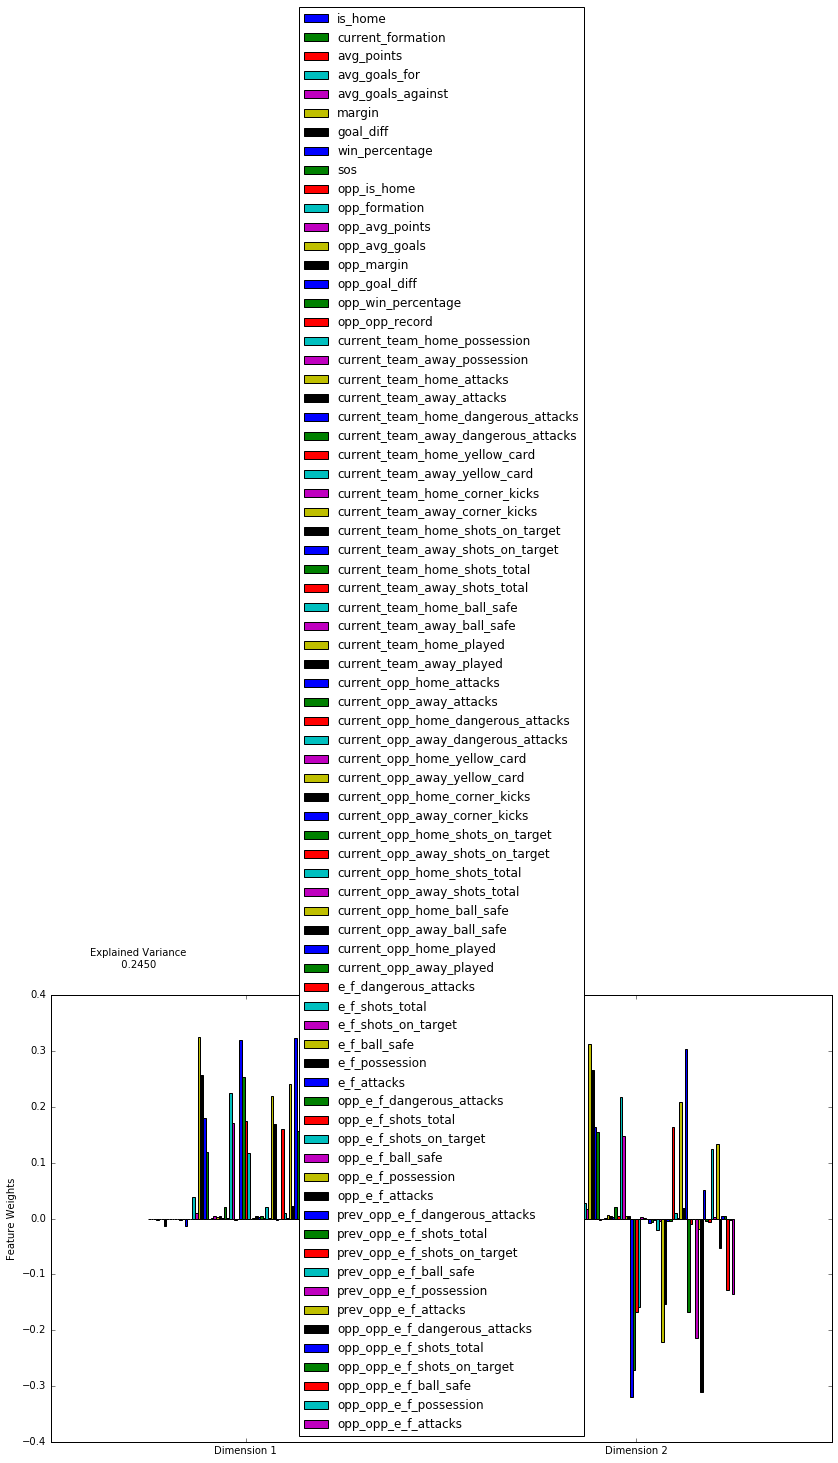

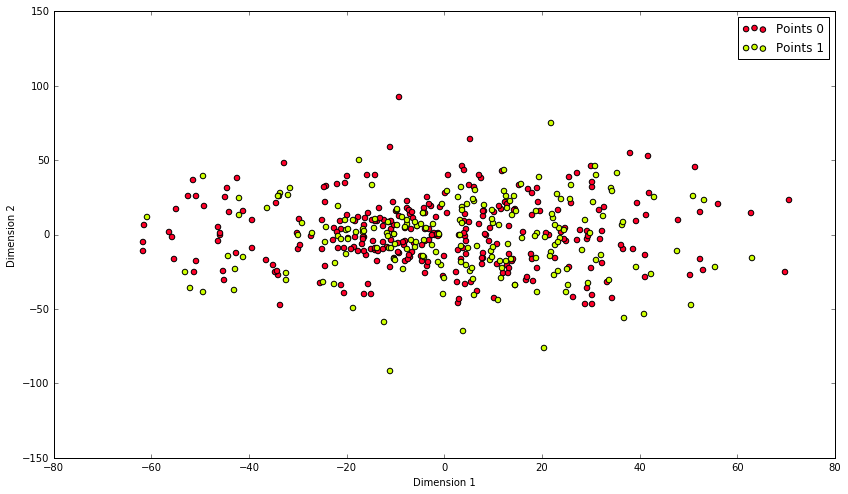

In [12]:
def plot_PCA(data, preds):
    
    pca = PCA(n_components=2)
    pca.fit(data)
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    
    #print(pca_results)
    #print(type(pca_results))
    reduced_data = pca.transform(data)
    # Create a DataFrame for the reduced data
    reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
    plot_data = pd.concat([preds, reduced_data], axis = 1)
    display(plot_data.head())
    fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('converted_points'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);
    
    return pca

pca = plot_PCA(nd_X, nd_y)

### RUNNING LINEAR REGRESSION on FEATURES

In [93]:
formations = []
for name in reg_data.groupby('current_formation').groups:
    formations.append(name)
    
nd = np.array(formations) 

for name in reg_data.groupby('opp_formation').groups:
    if name not in nd:
        print(nd.append(name))
        
for n in range(len(nd)):
    reg_data = reg_data.replace(nd[n], n)

reg_data = model_libs._clone_and_drop(reg_data, ignore_cols)
(reg_y, reg_X) = model_libs._extract_target(reg_data, 'goals')

display(reg_X.head())
display(reg_y.head())

,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,win_percentage,sos,opp_is_home,opp_formation,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_diff,opp_win_percentage,opp_opp_record,current_team_home_possession,current_team_away_possession,current_team_home_attacks,current_team_away_attacks,current_team_home_dangerous_attacks,current_team_away_dangerous_attacks,current_team_home_yellow_card,current_team_away_yellow_card,current_team_home_corner_kicks,current_team_away_corner_kicks,current_team_home_shots_on_target,current_team_away_shots_on_target,current_team_home_shots_total,current_team_away_shots_total,current_team_home_ball_safe,current_team_away_ball_safe,current_team_home_played,current_team_away_played,current_opp_home_attacks,current_opp_away_attacks,current_opp_home_dangerous_attacks,current_opp_away_dangerous_attacks,current_opp_home_yellow_card,current_opp_away_yellow_card,current_opp_home_corner_kicks,current_opp_away_corner_kicks,current_opp_home_shots_on_target,current_opp_away_shots_on_target,current_opp_home_shots_total,current_opp_away_shots_total,current_opp_home_ball_safe,current_opp_away_ball_safe,current_opp_home_played,current_opp_away_played,e_f_dangerous_attacks,e_f_shots_total,e_f_shots_on_target,e_f_ball_safe,e_f_possession,e_f_attacks,opp_e_f_dangerous_attacks,opp_e_f_shots_total,opp_e_f_shots_on_target,opp_e_f_ball_safe,opp_e_f_possession,opp_e_f_attacks,prev_opp_e_f_dangerous_attacks,prev_opp_e_f_shots_total,prev_opp_e_f_shots_on_target,prev_opp_e_f_ball_safe,prev_opp_e_f_possession,prev_opp_e_f_attacks,opp_opp_e_f_dangerous_attacks,opp_opp_e_f_shots_total,opp_opp_e_f_shots_on_target,opp_opp_e_f_ball_safe,opp_opp_e_f_possession,opp_opp_e_f_attacks,points
0,0,2,3.00,2.000000,0.000000,2.000000,2,1.000000,1.166667,1,2,1.000000,3.000000,0.000000,0,0.500000,0.5000,46.0,48.310725,93.000000,97.409953,59.000000,47.939359,1.000000,1.821787,8.000000,4.171249,9.000000,4.180421,12.0,8.140208,87.0,92.869165,1,0,65,97.409953,44,47.939359,1,1.821787,5,4.171249,5.000000,4.180421,14,8.140208,66,92.869165,1,0,59.000000,12.000000,9.000000,87.000000,46.000000,93.000000,44.000000,14.000000,5.000000,66.000000,48.00,65.000000,55.000000,5.000000,1.000000,91.000000,54.000000,92.000000,51.000000,13.000000,6.000000,75.000000,52.000000,74.000000,0
1,1,2,1.50,1.000000,2.500000,-1.500000,-3,0.500000,2.000000,0,2,3.000000,3.000000,2.000000,4,1.000000,0.0000,46.0,52.000000,93.000000,97.000000,59.000000,51.000000,1.000000,3.000000,8.000000,7.000000,9.000000,4.000000,12.0,6.000000,87.0,71.000000,1,1,119,101.000000,45,49.000000,1,1.000000,3,2.000000,7.000000,6.000000,10,11.000000,119,102.000000,1,1,55.000000,9.000000,6.500000,79.000000,49.000000,95.000000,47.000000,10.500000,6.500000,110.500000,49.50,110.000000,44.000000,10.000000,5.000000,79.000000,48.000000,78.000000,68.500000,6.500000,1.500000,108.000000,46.000000,132.000000,3
2,0,2,2.00,1.333333,1.666667,-0.333333,-1,0.666667,0.880952,1,12,0.666667,0.666667,-1.000000,-3,0.357143,0.5000,49.5,52.000000,106.500000,97.000000,65.500000,51.000000,1.500000,3.000000,6.500000,7.000000,8.000000,4.000000,14.5,6.000000,92.5,71.000000,2,1,135,79.000000,73,38.500000,1,3.500000,7,4.500000,5.000000,3.000000,11,5.500000,121,81.000000,1,2,60.666667,11.666667,6.666667,85.333333,50.333333,103.333333,50.000000,7.333333,3.666667,94.333333,46.00,97.666667,45.333333,8.666667,5.333333,112.333333,48.666667,113.666667,52.666667,9.333333,5.333333,96.666667,52.333333,100.333333,3
3,1,12,2.25,1.750000,1.250000,0.500000,2,0.777778,0.500000,0,2,0.333333,0.666667,-0.666667,-2,0.166667,0.3125,49.5,49.500000,106.500000,108.000000,65.500000,48.500000,1.500000,2.500000,6.500000,4.500000,8.000000,5.000000,14.5,7.500000,92.5,93.000000,2,2,101,94.000000,60,67.000000,0,1.500000,8,7.000000,7.000000,5.500000,15,11.000000,98,75.000000,1,2,57.000000,11.000000,6.500000,92.750000,49.500000,107.250000,64.666667,12.333333,6.000000,82.666667,57.00,96.333333,53.000000,7.500000,3.000000,97.5

0    0
1    2
2    3
3    1
4    2
Name: goals, dtype: float64

In [96]:
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(reg_X, reg_y, test_size=0.2, random_state=42)
regr.fit(X_train, y_train)
#print('Coefficients: \n', regr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print(y_test)
print(regr.predict(X_test))
print('Variance score: %.2f' % regr.score(X_test, y_test))

('Coefficients: \n', array([ -1.20255474e+06,  -1.66834226e-02,  -4.06822350e-01,
        -6.76086288e+09,   6.76086288e+09,   6.76086288e+09,
        -1.24609123e-02,   1.36506513e+00,  -1.77843306e+00,
        -1.20255461e+06,  -1.31071914e-02,  -7.66340915e-01,
        -1.16215108e-02,   4.01840343e-01,  -6.87487139e-03,
         6.30915286e+00,   7.13763122e-01,  -1.44595207e-01,
        -6.45579506e-02,   3.84150147e-02,   3.68220822e-02,
        -1.27410904e-02,  -2.03475710e-02,   8.97943845e-03,
        -1.00432927e-01,  -2.21952093e-02,  -2.63536895e-02,
        -1.45347841e-01,  -1.40741115e-01,   1.11632734e-01,
         3.28908180e-02,  -6.81624549e-03,  -1.77452586e-02,
        -6.51908020e-02,  -3.03531242e-02,   4.02330194e-03,
         6.22963400e-03,  -2.01864830e-02,  -2.76504750e-02,
         1.57208500e-01,   2.21977772e-02,   9.08008199e-02,
         9.82049052e-02,  -2.06354872e-01,  -1.07770076e-01,
         1.02060326e-01,   2.12738799e-01,   2.15600189e-02,
   

### STEP 1 - Tune Models

Tune models using their respective parameters if they have some.

In [ ]:
def train_tuned_models(round_num, X, y):
    for i in models:
        form_model.build_tuned_model(X, y, i)
        
train_tuned_models(round_number, raw_X, raw_y)

### STEP 2 - Optimizing Features
Using RFECV to see which features are the most pertinent.  Can only use SVC with RFECV.

In [ ]:
def plot_RFECV(X, y):
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
                  scoring='accuracy')
    rfecv.fit(X, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
plot_RFECV(raw_X, raw_y)

Using the RFE's ranking system we will use only the top 'x' number of features to try to find the optimial number of features (for SVC).  'X' is roughly determined by the number of features outputted in the RFECV plot.

In [ ]:
def create_RFE(X, y):
    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit(X, y)
    print(rfe.ranking_)
    return rfe.ranking_
   
rankings = create_RFE(raw_X, raw_y)

### STEP 3
Take ranked features and reordering the features so that we can use that DF in the new models

In [ ]:
def reorder_features(ranking, data):
    ranked_X = pd.DataFrame(index=range(480))
    for a in range(len(ranking)):
        for i in range(len(ranking)):
            if ranking[i] == a+1:
                ranked_X = ranked_X.join(data.ix[:,i])
    
    display(ranked_X.describe())
    return ranked_X


ranked_X = reorder_features(rankings, raw_X)

### STEP 4
Let's try to reduce the number of features to at least 25 although optimal seems likely around ~8 features.  Note: Even though RFECV only applies to SVC still running it on the other models just to see the impact.

In [ ]:
def train_ranked_models(X, y):
    
    for x in xrange(5, 25):
        print('X :: {}'.format(x))
        svc, gmm, knn, gnb = train_models(round_number, X.iloc[:, 1:x], y)
        
train_ranked_models(ranked_X, raw_y)

Plot PCA based off of optimized number in previous step

### STEP 5 Try PCA on ranked features 

In [ ]:
def plot_PCA(data):
    pca = PCA(n_components=7)
    pca.fit(data)
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    return pca

pca = plot_PCA(ranked_X)

In [ ]:
def apply_PCA(pca, data):
    # TODO: Apply a PCA transformation the good data
    pca_data = pca.transform(data)
    return pca_data
    
apply_PCA(pca, ranked_X.iloc[:, 1:23])

### STEP 6 Let's try removing ties on RAW DATA (All Features and Target)

In [ ]:
def remove_ties(data):
    tieless_data = data[data.points != 1]
    X, y = split_target(tieless_data)
    return X, y
    
X, y = remove_ties(raw_data)

log, svc, gmm, knn, gnb = train_models(round_number, X, y)

Starting with the Ranked Data, Removing Ties then 'extracting target' so we can reduce the features then run the models to find the optimal amount of features on data where there are no ties.

In [ ]:
print(ranked_X.shape)
ranked_data = ranked_X.join(raw_y)

tieless_X, tieless_y = remove_ties(ranked_data)

#'16' here is just the number where the optimal number of features was found above.  
svc, gmm, knn, gnb = train_models(round_number, tieless_X.iloc[:, 1:16], tieless_y)

## Part 2
Run all the above steps but using standard features and the Home/Away Features - Create Home/Away Data.  Home/Away Data is my attempt to try to split out the difference in how a current team's play varies from away and home.  For instance, instead of just averaging a teams goal scored from all games, average a teams goal scored on home games and away games.  If in that match they are the home team, only use the home average.  If they are away, use the away average.

In [ ]:
# ha = home-away
standard_cols = ['games_played', 'is_home', 'avg_points', 'goals_for', 'goals_against', 'avg_goals', 'margin', 'goal_diff',
                'win_percentage', 'sos', 'opp_avg_points', 'opp_avg_goals', 'opp_margin', 'opp_goal_diff', 'opp_win_percentage',
                'opp_opp_record', 'points']
# 17 each
home_cols = ['current_team_home_possession', 'current_team_home_attacks', 'current_team_home_dangerous_attacks', 'current_team_home_yellow_card',
            'current_team_home_corner_kicks', 'current_team_home_shots_on_target', 'current_team_home_shots_total', 'current_team_home_ball_safe',
            'current_team_home_played', 'current_opp_away_attacks', 'current_opp_away_dangerous_attacks', 'current_opp_away_yellow_card',
            'current_opp_away_corner_kicks', 'current_opp_away_shots_on_target', 'current_opp_away_shots_total', 'current_opp_away_ball_safe',
            'current_opp_away_played']
away_cols = ['current_team_away_possession', 'current_team_away_attacks', 'current_team_away_dangerous_attacks', 'current_team_away_yellow_card', 
            'current_team_away_corner_kicks', 'current_team_away_shots_on_target', 'current_team_away_shots_total', 'current_team_away_ball_safe', 
            'current_team_away_played', 'current_opp_home_attacks', 'current_opp_home_dangerous_attacks', 'current_opp_home_yellow_card', 'current_opp_home_corner_kicks', 
             'current_opp_home_shots_on_target', 'current_opp_home_shots_total', 'current_opp_home_ball_safe', 'current_opp_home_played']

def rename_column(label):
    if label.count('_home_') > 0:
        new_name = label.replace('_home_', '_')
    elif label.count('_away_') > 0:
        new_name = label.replace('_away_', '_')
    return new_name

# Creates new column list for merged columns
merged_cols = []

for cols in home_cols:
    merged_cols.append(rename_column(cols))
    
# Creates a Home and Away Table with Standard and Home/Away Columns.  Will evenutally merge together
ha_data = model_libs._clone_and_drop(raw_data, ignore_cols)
home_data = ha_data.loc[ha_data.loc[:, 'is_home'] == 1, standard_cols + home_cols]
away_data = ha_data.loc[ha_data.loc[:, 'is_home'] == 0, standard_cols + away_cols]

# Appends the Home Table with the Away Table
ha_data = home_data.append(away_data)

def pick_column(home, away):
    if np.isnan(home):
        return away
    elif np.isnan(away):
        return home

# Combine Home/Away Columns into one for Current Team and Opponent.  Cuts down on Features
# Adds from whatever column that doesn't have Nan
for c in range(len(merged_cols)):
    ha_data[merged_cols[c]] = ha_data.apply(lambda row: pick_column(row[home_cols[c]], row[away_cols[c]]), axis=1 )

ha_data = ha_data.drop(home_cols + away_cols, axis=1)

print(ha_data.shape)
display(ha_data.describe())

In [ ]:
ha_X, ha_y = split_target(ha_data)
print(' :: Split Home/Away Data :: ')
svc, gmm, knn, gnb = train_models(round_number, ha_X, ha_y)
print('\n :: Train Tuned Models on Home/Away Data - This will take awhile... :: ')
train_tuned_models(round_number, ha_X, ha_y)
print('\n :: Plotting RFECV to understand the optimal amount of features :: ')
plot_RFECV(ha_X, ha_y)
print('\n :: Ranking the features in terms of importance :: ')
ha_rankings = create_RFE(ha_X, ha_y)
print('\n :: Reordering the Home/Away Data in terms of ranked features :: ')
ha_ranked_X = reorder_features(ha_rankings, ha_X)
print('\n :: Training new ranked data and eliminating some features :: ')
train_ranked_models(ha_ranked_X, ha_y)
print('\n :: Plotting PCA to cut down on dimensions :: ')
ha_pca = plot_PCA(ha_ranked_X.iloc[:, 1:23])
print('\n :: Apply the PCA so we can use fewer dimensions :: ')
pca_data = apply_PCA(ha_pca, ha_ranked_X.iloc[:, 1:23])
print('\n :: Train models based on PCA Data :: ')
svc, gmm, knn, gnb = train_models(round_number, pca_data, raw_y)
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)
print('\n :: Joined the target value back to Ranked X :: ')
ha_ranked_data = ha_ranked_X.join(ha_y)
print('\n :: Removing Ties from the Ranked Features Data :: ')
ha_tieless_X, ha_tieless_y = remove_ties(ha_ranked_data)
print('\n :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: ')
svc, gmm, knn, gnb = train_models(round_number, ha_tieless_X.iloc[:, 1:16], ha_tieless_y)
print('\n :: Finished with Home/Away Features :: ')

## Part 3
Run all the above steps but using the standard features and the extended features.  Extended Features is an attempt to use not just the current team and the team they are playing in that match up.  But also to use compare the current teams previous opponents and the current teams opponents opponents.  

In [ ]:
# ef = extended features
ef_data = model_libs._clone_and_drop(raw_data, ignore_cols)
ef_data = ef_data.drop(home_cols + away_cols, axis=1)

ef_X, ef_y = split_target(ef_data)
print('\n :: Split Extended Features Data :: ')
svc, gmm, knn, gnb = train_models(round_number, ef_X, ef_y)
print('\n :: Train Tuned Models on Extended Features Data - This will take awhile... :: ')
train_tuned_models(round_number, ef_X, ef_y)
print('\n :: Plotting RFECV to understand the optimal amount of features :: ')
plot_RFECV(ef_X, ef_y)
print('\n :: Ranking the features in terms of importance :: ')
ef_rankings = create_RFE(ef_X, ef_y)
print('\n :: Reordering the Extended Features Data in terms of ranked features :: ')
ef_ranked_X = reorder_features(ha_rankings, ef_X)
print('\n :: Training new ranked data and eliminating some features :: ')
train_ranked_models(ef_ranked_X, ef_y)
print('\n :: Plotting PCA to cut down on dimensions :: ')
ef_pca = plot_PCA(ef_ranked_X.iloc[:, 1:23])
print('\n :: Apply the PCA so we can use fewer dimensions :: ')
pca_data = apply_PCA(ef_pca, ef_ranked_X.iloc[:, 1:23])
print('\n :: Train models based on PCA Data :: ')
svc, gmm, knn, gnb = train_models(round_number, pca_data, raw_y)
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)
print('\n :: Joined the target value back to Ranked X :: ')
ef_ranked_data = ef_ranked_X.join(ef_y)
print('\n :: Removing Ties from the Ranked Features Data :: ')
ef_tieless_X, ef_tieless_y = remove_ties(ef_ranked_data)
print('\n :: Training and then comparing Ranked Features against the Raw Data with Ties removed :: ')
svc, gmm, knn, gnb = train_models(round_number, ef_tieless_X.iloc[:, 1:16], ef_tieless_y)
print('\n :: Finished with Extended Features :: ')

Using desired model to predict upcoming matches :: Right now these are the best performing models with the best performing feature.  Seems just removing ties on the 'raw data' has the best impact 

In [ ]:
print('\n :: Removing Ties on Raw Data :: ')
X, y = remove_ties(raw_data)
print('\n :: Run Training on Removing Ties from the Raw Data :: ')
svc, gmm, knn, gnb = train_models(round_number, X, y)

### Part 4

Use these models trained on the optimal data to predict upcoming matches

Find upcoming matches...

In [ ]:
#upcoming_matches, match_details = predict_matches.get_upcoming_matches()
#upcoming_matches.to_csv('upcoming_matches.csv')
#match_details.to_csv('match_details.csv')
#print("Upcoming Data Saved to CSV")

upcoming_matches = pd.read_csv('upcoming_matches.csv')
upcoming_matches = upcoming_matches.drop(upcoming_matches.columns[[0]], axis=1)

match_details = pd.read_csv('match_details.csv')
match_details = match_details.drop(match_details.columns[[0]], axis=1)

display(upcoming_matches)

Make predictions on upcoming data

In [ ]:
from stats import predict_matches

for i in models:
    if i == 'svc':
        svc_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, svc)
        print(svc_preds)
    elif i == 'gmm':
        gmm_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, gmm)
        print(gmm_preds)
    elif i == 'knn':
        knn_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, knn)
        print(knn_preds)
    elif i == 'gnb':
        gnb_preds, upcoming_data = predict_matches.predictions(upcoming_matches, match_details, gnb)
        print(gnb_preds)
        
display(upcoming_data.head())

Output those predictions to a CSV so easier to visualize

In [ ]:
columns = ['team_name', 'opp_name', 'scheduled']
# Remove all columns except the ones above
upcoming_matches = upcoming_data[columns]

# Add predictions to the end of that DF
results = pd.DataFrame({'SVC': svc_preds, 'GMM': gmm_preds, 'KNN': knn_preds, 'GNB': gnb_preds})
upcoming_matches = upcoming_matches.join(results)
reordered_matches = pd.DataFrame([])

for rows in upcoming_matches.iterrows():
    for i in upcoming_matches['team_name']:
        if rows[1]['opp_name'] == i:
            reordered_matches = reordered_matches.append(rows[1])
            reordered_matches = reordered_matches.append(upcoming_matches[upcoming_matches['team_name'].isin([i])])

reordered_matches = reordered_matches.drop_duplicates() 
columns = ['scheduled', 'team_name', 'opp_name', 'SVC', 'KNN', 'GMM', 'GNB']
reordered_matches = reordered_matches[columns]
# upcoming_matches = upcoming_matches[(upcoming_matches['scheduled'] < '2016-08-26')]
reordered_matches.to_csv('predictions_' + str(round_number) + '.csv')
print('Prediction CSV saved')

### RESULTS

Excluding GMM...

FC Dallas vs Portland Timbers :: 3-1 (Unanimously Dallas)
New England Revolution vs Colorado Rapids :: 2-0 (Mixed, 1 model picked NER to win)
New York City FC vs DC United :: 3-2 (Unanimously NYCFC)
Chicago Fire vs Philadelphia Union :: 3-0 (2 models picked Chi and 1 picked Phi)
Vancouver Whitecaps vs New York Red Bulls :: 0-1 (WRONG, 2 models picked Vancouver to win)
LA Galaxy vs Columbus Crew :: 2-1 (2 models picked LA to win)

My Questions:
- For GMM, how can we tell what classification it's predicting.  If you notice in the predictions CSV it says 0, 1, 2.  How do I know which one of those are win, draw, or a loss (3, 1, 0)?